#Laborator 4

In cadrul acestui laborator o sa lucram cu blocurile de baza necesare construirii unor retele mai complexe. De interes sunt:


*   Residual Blocks
*   Inception Blocks

Pe langa acestea, o sa aplicam si augmentari generale de date care au rolul de a face modelul robust la variatii mici. 



## Operatii Noi

Urmatoarele operatii vor fi folosite in cadrul laboratorului

Tensor shape: (batch,channels,dim1,dim2)


*  **torch.cat(tensors, dim=0).** Tensorii trebuie sa aiba aceleasi dim1,dim2, dar channels poate sa difere.
*  **torch.add(input, other)**. Tensorii trebuie sa aiba aceleasi dimensiune pe toate axele.





In [0]:
import numpy as np
import torch.nn as nn
import torch

dummy_input_tensor1 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale
dummy_input_tensor2 = torch.rand((1,5,100,100))  # Input random de marime 100x100 cu 5 canale

# Normal se concateneaza pe dimensiunea canalelor.
x = torch.cat([dummy_input_tensor1,dummy_input_tensor2],dim=1) 
print(x.shape) # Numarul de canele_output = canale_input2 + canale_input1

dummy_input_tensor1 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale
dummy_input_tensor2 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale

x = torch.add(dummy_input_tensor1,dummy_input_tensor2)
print(x.shape) 

torch.Size([1, 8, 100, 100])
torch.Size([1, 3, 100, 100])


##Residual Block

In cadrul Resnet se utilizeaza residual connections / skip connections, care impreuna cu un path normal, ca cele implementate pana acum, formeaza un residual block. 

![resnetBlock](https://drive.google.com/uc?id=1fa4uuMBY4qmDbk4Tanu3CT-1E4nYq_He)

###Cerinte

Implementati ResidualBlock. Acesta duce input tensor in ($c_{input}$,width,height) in  ($c_{out}$,width,height) sau  ($c_{out}$,width/2,height/2) in functie de stride.




In [0]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F

class ResidualBlock(nn.Module):
  def __init__(self,input_channels=32,hidden_channels=64,output_channels=64,kernel_size=3,stride=1,activation=nn.ReLU()):
    super(ResidualBlock,self).__init__()
    
    layers = []

    # Your code here
    # layers.append: Conv2d => activation ReLU => Conv2d
    layers.append(nn.Conv2d(input_channels, hidden_channels, kernel_size, stride, padding=18))
    layers.append(activation)
    layers.append(nn.Conv2d(hidden_channels, output_channels, kernel_size, stride, padding=17))

    self.net_normal = nn.Sequential(*layers) # =>must also return torch.Size([1, 128, 50, 50])

    self.net_residual = nn.Conv2d(input_channels,output_channels,1,stride) # => torch.Size([1, 128, 50, 50])

  def forward(self,x):
    x1 = self.net_normal(x)
    # print(x1.shape)
    x2 =self.net_residual(x)
    # print(x2.shape)
    x = torch.cat([x1,x2],1)
    x = F.relu(x)
    return x

block = ResidualBlock(3,64,128,3,2,nn.ReLU()) # input = 3 || hidden = 64 || out = 128 || kernel_size = 3 || stride = 2 || activation = ReLu
x = torch.rand(size=(1,3,100,100))
# print(x.shape)

# Should output torch.Size([1, 256, 50, 50])
print(block(x).shape)

torch.Size([1, 256, 50, 50])


##Inception Block

In cadrul GoogleNet/InceptionNet este folosit Inception Block, care este alcatuit din mai multe miniretele putin diferite, care se unesc la finalul Inception Block

### Cerinta

Implementati Inception Block. Acesta trebuie sa duca un Tensor ($ch_{input}$,w,h) in ($ch_{out}$,w/2,h/2)

![InceptionBlock](https://drive.google.com/uc?id=1OOLqfHZSIdQp6xO1T8cUpgjmfkMgGDuU)

In [0]:
# https://pytorch.org/docs/stable/nn.html -> Hout & Wout formulae

# Layers: 
# Conv2d - changes dim + choose output_channels
# BatchNorm2d - !changes dim
# activation - !changes dim
# MaxPool2d- changes dim

import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F


class InceptionBlock(nn.Module):
  def __init__(self,input_channels=32,kernel_size=3,stride=1,activation=nn.ReLU()):
    super(InceptionBlock,self).__init__()

    layers = []
       # Your code here
    layers.append(nn.Conv2d(input_channels, input_channels//4, kernel_size, stride, padding = 50))
    layers.append(nn.BatchNorm2d(input_channels//4))
    layers.append(activation)

    layers.append(nn.Conv2d(input_channels//4, input_channels//2, kernel_size, stride, padding = 50))
    layers.append(nn.BatchNorm2d(input_channels//2))
    layers.append(activation)

    layers.append(nn.Conv2d(input_channels//2, input_channels//2, kernel_size, stride, padding = 1))
    layers.append(nn.BatchNorm2d(input_channels//2))
    layers.append(activation)

    self.path1 = nn.Sequential(*layers)

    layers = []
       # Your code here
    layers.append(nn.Conv2d(input_channels, input_channels//4, kernel_size, stride, padding = 18))
    layers.append(nn.BatchNorm2d(input_channels//4))
    layers.append(activation)

    layers.append(nn.Conv2d(input_channels//4, input_channels//2, kernel_size, stride, padding = 17))
    layers.append(nn.BatchNorm2d(input_channels//2))
    layers.append(activation)

    self.path2 = nn.Sequential(*layers)

    layers = []
       # Your code here
    layer = nn.MaxPool2d(kernel_size, stride, padding=1) 
    layers.append(nn.Conv2d(input_channels, input_channels//2, kernel_size, stride, padding = 1))
    layers.append(nn.BatchNorm2d(input_channels//2))
    layers.append(activation)

    self.path3 = nn.Sequential(*layers)

    layers = []
       # Your code here
    layers.append(nn.Conv2d(input_channels, input_channels//2, kernel_size, stride, padding = 1))
    layers.append(nn.BatchNorm2d(input_channels//2))
    layers.append(activation)

    self.path4 = nn.Sequential(*layers)


  def forward(self,x):
    x1 = self.path1(x)
    # print(x1.shape)
    x2 =self.path2(x)
    # print(x2.shape)
    x3 =self.path3(x)
    # print(x3.shape)
    x4 =self.path4(x)
    # print(x4.shape)
    x = torch.cat([x1,x2,x3,x4],1)
    return x



block = InceptionBlock(64,3,2,nn.ReLU())
x = torch.rand(size=(1,64,100,100))
# Should output torch.Size([1, 128, 50, 50])
print(block(x).shape)

torch.Size([1, 128, 50, 50])


###Cerinta

Construiti o retea, utilizand blocurile scrise mai sus care sa duca un input de la (1,3,128,128) in (1,$channels_{out}$).

## Instantierea seturilor de date

In acest laborator lucram cu un nou set de date. Este vorba de un subset al faimosului ImageNet, pisicile din ImageNet. ImageNet este utilizat pentru clasificare in mod normal, dar [acest concurs](https://www.kaggle.com/c/imagenet-object-localization-challenge) l-a adnotat pentru clasificare si localizare. Urmeaza 2 blocuri de download si dezarhivare date.

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18t4uPwAZ_5a6P9srPGY-VHmgDkUbCPCI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18t4uPwAZ_5a6P9srPGY-VHmgDkUbCPCI" -O CatsImageNet.tar.xz && rm -rf /tmp/cookies.txt

--2020-05-02 20:39:01--  https://docs.google.com/uc?export=download&confirm=k6YH&id=18t4uPwAZ_5a6P9srPGY-VHmgDkUbCPCI
Resolving docs.google.com (docs.google.com)... 108.177.111.138, 108.177.111.113, 108.177.111.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.111.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-5g-docs.googleusercontent.com/docs/securesc/7f09380ogq9h3hboqkjguh6ghe1nbhgu/gdeqf2ihhnqetdu7ur7qh3qq24i23el7/1588451925000/02831014641652451217/10803903338540888896Z/18t4uPwAZ_5a6P9srPGY-VHmgDkUbCPCI?e=download [following]
--2020-05-02 20:39:01--  https://doc-14-5g-docs.googleusercontent.com/docs/securesc/7f09380ogq9h3hboqkjguh6ghe1nbhgu/gdeqf2ihhnqetdu7ur7qh3qq24i23el7/1588451925000/02831014641652451217/10803903338540888896Z/18t4uPwAZ_5a6P9srPGY-VHmgDkUbCPCI?e=download
Resolving doc-14-5g-docs.googleusercontent.com (doc-14-5g-docs.googleusercontent.com)... 108.177.111.132, 2607:f8b0:4001:c07::84
Conne

In [0]:
!tar xf CatsImageNet.tar.xz
!ls

CatsImageNet.tar.xz  n02123045	n02123394  n02124075
dataset.csv	     n02123159	n02123597  sample_data


## Crearea Dataloader-ului

In continuare, pentru a incarca date, sa o folosim un obiect mai complex, un Torch.utils.data.Dataset. Acesta are 3 functii importante:


*   __init__()
*   ____len____()
*  ____get_item____()



In [0]:
import torch as t
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random
random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

class CatsDataset(Dataset):
    def __init__(self, dataset_lines, width=128, height=128):
        """
        Args:
            dataset_lines (array): array of strings of form "{image_path}|{rectangle_coordinates}".
            width (int): target image width.
            height (int): target image height.
        """
        self.imgs_paths = [ln.split("|")[0] + ".JPEG" for ln in dataset_lines]
        self.points = [list(map(int, ln.split("|")[-1].split(" ")))
                        for ln in dataset_lines]
        self.img_size = (width, height)

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        img = Image.open(self.imgs_paths[idx])

        original_width, original_height = img.size

        img = img.resize(self.img_size)
        img = np.array(img)

        if len(img.shape) == 2:
          img = np.expand_dims(img, axis=2)
          img = np.repeat(img, 3, axis=2)

        x1, y1, x2, y2 = self.points[idx]

        x1 = x1 / original_width * self.img_size[0]
        x2 = x2 / original_width * self.img_size[0]
        y1 = y1 / original_height * self.img_size[1]
        y2 = y2 / original_height * self.img_size[1]

        coordinates = np.array([x1, y1, x2, y2])

        return img, coordinates



Construire Dataset si vizualizare date.

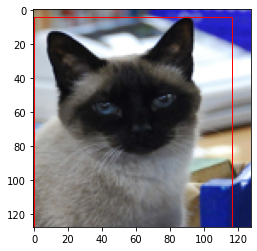

In [0]:
from IPython.display import clear_output
import time

train_test_proportion = .85

samples = [ln.strip() for ln in open("./dataset.csv")]
random.shuffle(samples)
train_samples = samples[:int(train_test_proportion*len(samples))]
test_samples = samples[int(train_test_proportion*len(samples)):]

cats_train = CatsDataset(train_samples)
cats_test = CatsDataset(test_samples)
train_loader = DataLoader(cats_train, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(cats_test, batch_size=16, shuffle=False, num_workers=4)

see_examples = 10
for i, (imgs, coordinates) in enumerate(train_loader):
    clear_output(wait=True)
    plt.imshow(imgs[0])

    x1, y1, x2, y2 = coordinates[0]
    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()

    if i >= see_examples - 1:
      break
    time.sleep(1)


## Crearea unei retele neurale convolutionale

### Cerinte
 * Creati o clasa ce mosteneste din clasa nn.Module ce reprezinta o retea neurala convolutionala pentru regresie de 4 coordonate pe datasetul ImageNet Cats.


#### Hint

Pentru a liniariza iesirea din cel de-al doilea feature map puteti adopta mai multe strategii:
  * Liniarizare prin schimbarea shape-ului la [batch_size, -1]
  * Global Max Pooling si apoi liniarizare la [batch_size, -1]
  * Average Max Pooling si apoi liniarizare la [batch_size, -1]
  
La final trebuie utilziata o functie de activare care acopera [0,$\infty$)

In [0]:
import torch.nn as nn

class Net(nn.Module):

     # Your code here
  def __init__(self, in_channels=32, out_channels=64, kernel_size=3, stride=2, activation = nn.ReLU()):
    super(Net, self).__init__()

    layers = []
    layers.append("some layers here")
    self.net = nn.Sequential(*layers)

    self.activation = activation

  def forward(self,x):
     # Your code here

    x = x.view(x.shape[0],-1) # Liniarizare prin schimbarea shape-ului la [batch_size, -1]
    x = self.activation(x) # La final trebuie utilziata o functie de activare care acopera [0,infinit)
    
    return self.net(x)

## Definirea obiectelor folosite in timpul antrenarii

### Cerinte
  * Numarul de epoci
  * Retea
  * Optimizator

In [0]:
import torch.optim as optim

# Definiti numarul de epoci
epochs = 10

# Definiti reteaua
network = Net()

# Definiti optimizatorul
optimizer = optim.Adam(network.parameters(),lr=1e-3)

# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
# Completati codul pentru a face gradientii zero aici
optimizer.zero_grad()

# Definiti functia cost pentru pentru regressie
loss_fn = nn.CrossEntropyLoss()

## Definirea functiei de antrenare

In [0]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def train_fn(epochs: int, train_loader: data.DataLoader, test_loader: data.DataLoader, 
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):
  # Iteram prin numarul de epoci
  for e in range(epochs):
    # Iteram prin fiecare exemplu din dataset
    for images, coords in train_loader:

      # Aplicam reteaua neurala pe imaginile de intrare
      out = net(images)
      # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
      loss = loss_fn(out, labels)
      # Aplicam algoritmul de back-propagation
      loss.backward()
      # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
      optimizer.step()
      # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
      optimizer.zero_grad()
    
    print("Loss-ul la finalul epocii {} are valoarea {}".format(e, loss.item()))

    # Caluculul acuratetii
    count = len(test_loader)
    IOU_list = []

    for test_image, box_gt in test_loader:
      box_pred = torch.argmax(net(test_image))
      IOU_list.append(bb_intersection_over_union(box_pred,box_gt))

    print("Acuratetea la finalul epocii {} este {:.2f}%".format(e, (correct / count) * batch_size))

## Antrenarea

### Cerinte
  * Antrenati prima retea
  * Modificati celula de mai sus pentru a antrena LeNet si rulati din nou celula
  * Antrenati reteaua LeNet

In [0]:
train_fn(epochs, train_loader, test_loader, network, loss_fn, optimizer)

## Augmentare date

O metoda foarte buna pentru a creste performanta modelului este augmentarea setului de date. Aceste augmentari trebuie sa tina cont de natura taskului si de natura etichetelor. In cazul unui Flip Horizontal, stanga devinde dreapta.

### Cerinta

Modificati dataloaderul precedent astfel incat sa produca, cu o probabilitate de 0.5, date asupra carora s-a aplicat Flip Horizontal. Reantrenati modelul si observati daca apare o schimbare in performanta.

In [0]:
import torch as t
from PIL import Image, ImageOps
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
# import random
# random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

class CatsDataset(Dataset):
    def __init__(self, dataset_lines, width=128, height=128):
        """
        Args:
            dataset_lines (array): array of strings of form "{image_path}|{rectangle_coordinates}".
            width (int): target image width.
            height (int): target image height.
        """
        self.imgs_paths = [ln.split("|")[0] + ".JPEG" for ln in dataset_lines]
        self.points = [list(map(int, ln.split("|")[-1].split(" ")))
                        for ln in dataset_lines]
        self.img_size = (width, height)

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx): # flip flip
        img = Image.open(self.imgs_paths[idx])
        
        # should we want random flip:
        # flip = random.choice([0,1])
        # if flip == 1:

        # 0.5 probability of flip
        if idx % 2 == 0
          img = ImageOps.flip(img)

        original_width, original_height = img.size

        img = img.resize(self.img_size)
        img = np.array(img)

        if len(img.shape) == 2:
          img = np.expand_dims(img, axis=2)
          img = np.repeat(img, 3, axis=2)

        x1, y1, x2, y2 = self.points[idx]

        x1 = x1 / original_width * self.img_size[0]
        x2 = x2 / original_width * self.img_size[0]
        y1 = y1 / original_height * self.img_size[1]
        y2 = y2 / original_height * self.img_size[1]

        coordinates = np.array([x1, y1, x2, y2])

        return img, coordinates

